# 参考资料

[sklearn聚类算法官网](https://scikit-learn.org/stable/modules/clustering.html#)

[sklearn-kmeans](https://www.cnblogs.com/pinard/p/6169370.html)

[音乐分类](https://www.w3cschool.cn/article/220747)


# 引入包及云端硬盘


挂载google云端硬盘，使用云端硬盘的文件（音乐文件）

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


导入引用的包

In [3]:
%matplotlib inline
import os
import wave
import struct
import subprocess
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# 处理wav，提取特征值

## 特征值计算函数
- 时域特征
- 频域特征

我们人为地选取了42个音频数据的特征: 4x4+4x4+10=42

① 歌曲波形的统计矩，包括均值、标准差、偏态和峰态，同时，我们通过平滑窗(递增平滑，长度分别为1,10,100,1000)来获取这些特征在不同时间尺度上的表现；

② 为了体现信号的短时变化，我们可以计算一下波形一阶差分幅度的统计矩，同样也通过平滑窗来获取这些特征(均值、标准差、偏态和峰态)在不同时间尺度上的表现；

③ 最后，我们计算一下波形的频域特征，这里我们只计算歌曲在不同频段(将整个频段均分为10份)的能量占比，不过直接对歌曲的波形数据作快速傅里叶变换的话其计算量过于庞大了，因此先让波形数据通过长度为5的平滑窗再对其作快速傅里叶变换。


In [4]:
# Function:
# 	提取时域特征
def TFeatures(x):
    # 均值
    mean = x.mean()
    # 标准差
    std = x.var() ** 0.5
    # 偏态
    skewness = ((x - mean) ** 3).mean() / std ** 3
    # 峰态
    kurtosis = ((x - mean) ** 4).mean() / std ** 4
    return [mean, std, skewness, kurtosis]


# Function:
# 	提取频域特征
def FFeatures(x):
    x = np.array(x)
    x = x.reshape(-1, 5).mean(1)
    fft = np.fft.fft(x)
    fft = fft[2: (fft.size // 2 + 1)]
    fft = abs(fft)
    power = fft.sum()
    fft = np.array_split(fft, 10)
    return [i.sum() / power for i in fft]


# Function:
# 	计算每个音乐文件的特征
def ComputeFeatures(x):
    x = np.array(x)
    fv = []
    # Part1
    xs = x
    diff = xs[1:] - xs[:-1]
    fv.extend(TFeatures(xs))
    fv.extend(TFeatures(diff))
    # Part2
    xs = x.reshape(-1, 10).mean(1)
    diff = xs[1:] - xs[:-1]
    fv.extend(TFeatures(xs))
    fv.extend(TFeatures(diff))
    # Part3
    xs = x.reshape(-1, 100).mean(1)
    diff = xs[1:] - xs[:-1]
    fv.extend(TFeatures(xs))
    fv.extend(TFeatures(diff))
    # Part4
    xs = x.reshape(-1, 1000).mean(1)
    diff = xs[1:] - xs[:-1]
    fv.extend(TFeatures(xs))
    fv.extend(TFeatures(diff))
    # Part5
    fv.extend(FFeatures(x))
    return fv

## 读取wav文件并提取特征值

In [5]:
# Function:
# 	读取WAV文件
# Input:
# 	wavname(str): .wav文件名
# 	n_minutes(float): 提取.wav文件前n_minutes分钟的数据,优先级低
# 	is_entire(bool): 是否提取.wav文件的所有数据,优先级高
# Output(tuple):
# 	如果is_entire为True则返回.wav文件的所有数据+文件参数,
# 	否则返回前15s的数据+文件参数
def read_wav(wavname,is_entire=False):
    wavfile = wave.open(wavname)
    params = wavfile.getparams()
    if is_entire is True:
        num = params[3] // 1000 * 1000
        frames = wavfile.readframes(num)
        data = struct.unpack('%dh' % num, frames)
        wavfile.close()
    else:
        num = int(15 * 10000)
        if params[3] < num:
            raise ValueError('Wave file is too short...')
        frames = wavfile.readframes(num)
        data = struct.unpack('%dh' % num, frames)
        wavfile.close()
    return data, params

tar_path = '/content/drive/My Drive/wav'
fvs = []
fvs_names = []
for file in os.listdir(tar_path):
  x, params = read_wav(os.path.join(tar_path, file), is_entire=False)
  fv = ComputeFeatures(x)
  fvs_names.append(file[:-4]) # 获取文件名
  fvs.append(fv) # 获取文件42个维度数据
  if len(fvs)%50==0:
    print("正在处理"+str(len(fvs)-50)+"-"+str(len(fvs))+"首音乐")
  
fvs = np.array(fvs)
# print(params) wav文件的三个参数
print("共处理"+str(len(fvs))+"首音乐！")
print("42个特征值参数示例：\n",fvs[0]) # 全部音乐文件的42个维度参数

正在处理0-50首音乐
正在处理50-100首音乐
正在处理100-150首音乐
正在处理150-200首音乐
正在处理200-250首音乐
正在处理250-300首音乐
正在处理300-350首音乐
正在处理350-400首音乐
共处理408首音乐！
42个特征值参数示例：
 [-1.81274667e+00  4.85551445e+03  7.30564714e-03  8.78663463e+00
  6.01004007e-02  1.92796356e+03  7.06183458e-02  1.91142665e+01
 -1.81274667e+00  4.02800519e+03  5.63846793e-02  7.28094352e+00
  6.95719715e-01  4.05613342e+03  1.03757372e-01  1.69092175e+01
 -1.81274667e+00  1.50972665e+03  4.04063941e-01  2.88537961e+01
  2.64614410e+00  2.79117333e+03 -3.86858420e-01  2.78143869e+01
 -1.81274667e+00  1.23477299e+02 -1.21635250e+00  9.63880872e+00
 -6.95033557e-01  1.96755161e+02 -2.37097724e-01  1.17330482e+01
  2.46958941e-01  1.78670018e-01  1.01240820e-01  8.17153977e-02
  7.29447168e-02  1.38984818e-01  4.97823572e-02  4.31383981e-02
  4.57234776e-02  4.08410556e-02]


### 特征值优化筛选最终特征向量
我们已经计算了 42 种不同的特征值，但并非所有特征值都可用于决定两首歌曲听起来是否相同。下一步是找到这些要素的最佳子集，这些要素可以很好地协同工作，这样，在这个缩小的要素空间中，两个特征矢量之间的欧几里德距离与两首歌曲与人耳的相似声音相关。

变量选择的过程是一个受监督的机器学习问题，因此我们需要一组训练数据来帮助指导算法找到变量的最佳子集。我没有手动浏览我的音乐收藏并标记哪些歌曲听起来类似于为算法创建训练集，而是使用了更简单的方法：从每首歌曲中抽取两个 1 分钟的样本，并尝试找到一种算法，该算法可以最好地将每首歌曲中的两个样本匹配在一起。

为了找到在所有歌曲中提供最佳平均匹配功能集，我们使用遗传算法（R 中的 genalg 包）来打开和关闭 42 个变量中的每个变量。最终选取了18个音乐特征向量。

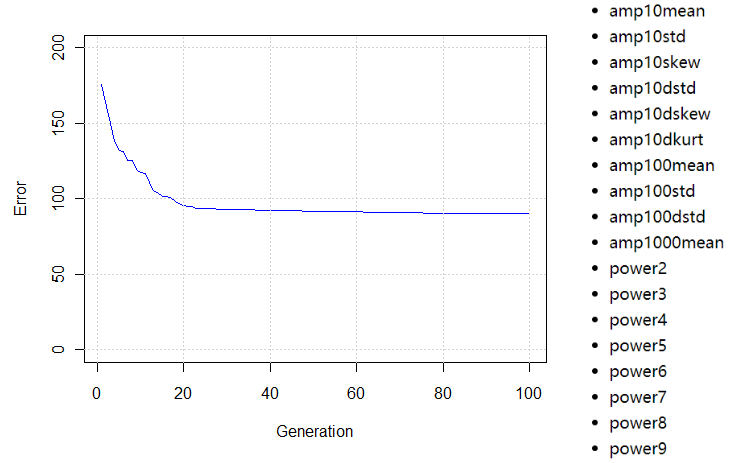

In [6]:
new_fvs=[]
for fv in fvs:
  fv = [fv[8], fv[9], fv[10], fv[13], fv[14], fv[15], fv[16], fv[17], fv[21], fv[24], fv[33], fv[34], fv[35],
        fv[36], fv[37], fv[38], fv[39], fv[40]]
  new_fvs.append(fv)
fvs=new_fvs
print(fvs)

[[-1.812746666666667, 4028.0051868795044, 0.05638467934021543, 4056.133420386705, 0.10375737220152441, 16.909217450402384, -1.8127466666666656, 1509.7266461650784, 2791.1733253184025, -1.8127466666666692, 0.17867001812258207, 0.10124081962602147, 0.08171539773890828, 0.07294471675791082, 0.13898481795074524, 0.0497823571595024, 0.043138398067632575, 0.04572347762964151], [10.222919999999991, 9469.89328642796, -0.3240322978156969, 5546.966426337664, 0.17989176470129792, 3.479149251233481, 10.222920000000002, 3719.372196100574, 6118.007431527784, 10.222920000000002, 0.1840532251962089, 0.09099205013829194, 0.0812222676050439, 0.04145892429996804, 0.03497340568547235, 0.021379811425655797, 0.02482097201408506, 0.014713594440257096], [3.127240000000003, 5086.788012388628, 0.1696739326456627, 4123.771251305565, 0.22641398087046982, 6.37078634776142, 3.1272399999999987, 2798.2498171213824, 4158.40008783052, 3.127240000000002, 0.19493566862676345, 0.1535394137037057, 0.08545616733758384, 0.05

In [7]:
#print("18个特征值参数示例：\n",fvs[0]) # 提取的18个维度特征值数据
print("18个特征值参数示例：") # 提取的18个维度特征值数据
for i in range(0,18):
  print(fvs[0][i])

18个特征值参数示例：
-1.812746666666667
4028.0051868795044
0.05638467934021543
4056.133420386705
0.10375737220152441
16.909217450402384
-1.8127466666666656
1509.7266461650784
2791.1733253184025
-1.8127466666666692
0.17867001812258207
0.10124081962602147
0.08171539773890828
0.07294471675791082
0.13898481795074524
0.0497823571595024
0.043138398067632575
0.04572347762964151


### 归一化和降维处理
对获取的10个维度的特征值进行归一化处理和PCA降维得到二维数据

In [11]:
scaler = StandardScaler()
scaler.fit(fvs)
fvs = scaler.transform(fvs)
model_pca = PCA(n_components=2).fit(fvs)
fvs = model_pca.transform(fvs)
print("归一化+降维后数据：\n",fvs[0])
print("文件名称：\n",fvs_names[0])
print(len(fvs_names))
print(len(fvs))

归一化+降维后数据：
 [ 3.35108347 -0.32645089]
文件名称：
 叫我baby
408
408


# 引入sklearn-kmeans聚类


原始数据

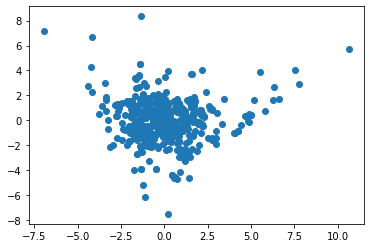

In [12]:
f1 = [x[0] for x in fvs]
f2 = [x[1] for x in fvs]

X = np.array(list(zip(f1, f2)))
plt.scatter(X[:, 0], X[:, 1], marker='o')
plt.show()

## 传统KMeans算法
KMeans算法通过尝试在等方差组中分离样本来对数据进行聚类，从而最小化称为惯性或聚类内平方和的标准。此算法要求指定群集数。它可很好地扩展到大量的样品中，并已被广泛应用于许多不同的领域。

k-means算法将一组样本划分为不相交的聚类，每个样本都用群集中样本的均值描述。这些手段通常称为聚类"中心";请注意，它们一般不是来自 的点，尽管它们生活在同一个空间中。

正在绘制k=5时的图片
正在绘制k=6时的图片
正在绘制k=7时的图片
正在绘制k=8时的图片
正在绘制k=9时的图片
正在绘制k=10时的图片
正在绘制k=11时的图片
正在绘制k=12时的图片


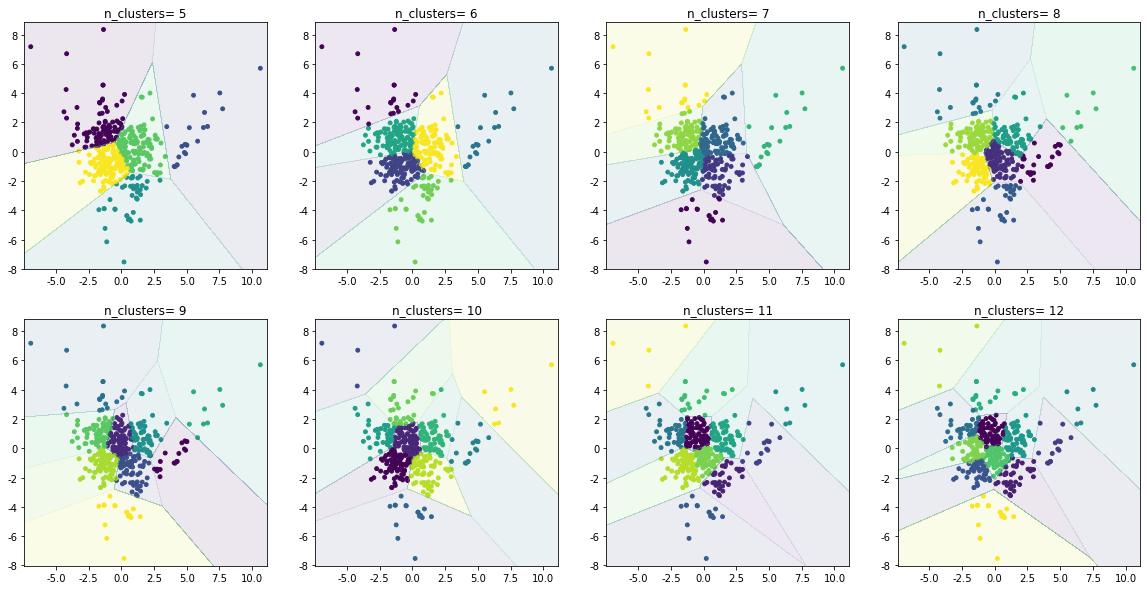

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import calinski_harabasz_score
plt.figure(figsize=(20,10)) # 放大图片

for k in range(5,13):
  print("正在绘制k={}时的图片".format(k))

  # 设置子图格式（两行四列，第三个参数是图片的index）
  plt.subplot(2,4,k-4)
  # 实例化k-means分类器，设置不同的k值，并计算评估系数
  clf = KMeans(n_clusters=k, random_state=9)
  y_pred = clf.fit_predict(X)
  score= calinski_harabasz_score(X, y_pred) 
  # plt绘图，设置标题，色块，文本内容等
  plt.title("n_clusters= {}".format(k))
  plt.scatter(X[:, 0], X[:, 1], c=y_pred , s= 15)
  #plt.text(.99, .01, ('score: %.2f' % (score)),transform=plt.gca().transAxes, size=20,horizontalalignment='right')
  ex = 0.5
  step = 0.01
  xx, yy = np.meshgrid(np.arange(X[:, 0].min() - ex, X[:, 0].max() + ex, step),
                      np.arange(X[:, 1].min() - ex, X[:, 1].max() + ex, step))
  zz = clf.predict(np.c_[xx.ravel(), yy.ravel()])
  zz.shape = xx.shape
  plt.contourf(xx, yy, zz, alpha= 0.1)

plt.show()

## MiniBatchKMeans算法
MiniBatchKMeans是KMeans算法的变体，该算法使用小型批处理来缩短计算时间，同时仍在尝试优化相同的目标函数。小型批处理是输入数据的子集，在每个训练迭代中随机采样。这些小型批处理大大减少了收敛到本地解决方案所需的计算量。与其他减少 k-means 收敛时间的算法相比，小批 k-means 产生的结果通常只比标准算法稍差。

正在绘制k=5时的图片
正在绘制k=6时的图片
正在绘制k=7时的图片
正在绘制k=8时的图片
正在绘制k=9时的图片
正在绘制k=10时的图片
正在绘制k=11时的图片
正在绘制k=12时的图片


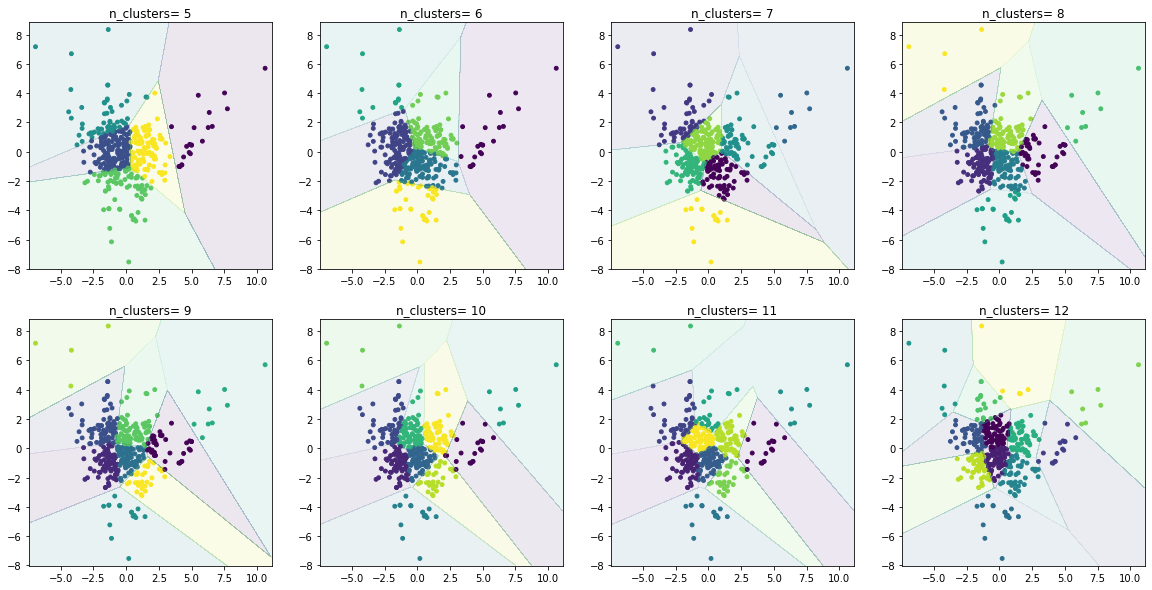

In [13]:
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import calinski_harabasz_score
plt.figure(figsize=(20,10)) # 放大图片

for k in range(5,13):
  print("正在绘制k={}时的图片".format(k))

  # 设置子图格式（两行四列，第三个参数是图片的index）
  plt.subplot(2,4,k-4)
  # 实例化k-means分类器，设置不同的k值，并计算评估系数
  clf = MiniBatchKMeans(n_clusters=k, batch_size = 400, random_state=9)
  y_pred = clf.fit_predict(X)
  score= calinski_harabasz_score(X, y_pred) 
  # plt绘图，设置标题，色块，文本内容等
  plt.title("n_clusters= {}".format(k)) 
  plt.scatter(X[:, 0], X[:, 1], c=y_pred , s= 15)
  #plt.text(.99, .01, ('score: %.2f' % (score)),transform=plt.gca().transAxes, size=20,horizontalalignment='right')
  ex = 0.5
  step = 0.01
  xx, yy = np.meshgrid(np.arange(X[:, 0].min() - ex, X[:, 0].max() + ex, step),
                      np.arange(X[:, 1].min() - ex, X[:, 1].max() + ex, step))

  zz = clf.predict(np.c_[xx.ravel(), yy.ravel()])
  zz.shape = xx.shape
  plt.contourf(xx, yy, zz, alpha= 0.1)

plt.show()

输出看看


In [ ]:
k=10
clf = MiniBatchKMeans(n_clusters=k, batch_size = 400, random_state=9)
y_pred = clf.fit_predict(X)
print(y_pred)
music_classes=[]
for x in range(0,k):
  music_classes.append([])
  for i in range(0,len(y_pred)):
    if y_pred[i]==x:
      music_classes[x].append(fvs_names[i])
  print("class %d [数量：%d]："%(x,len(music_classes[x])))
  print(music_classes[x])
#print(music_classes)

  

[0 1 3 0 3 1 2 4 6 3 9 1 6 9 3 2 1 1 9 0 9 2 9 0 1 9 4 6 8 6 9 2 6 6 4 9 6
 3 6 1 7 1 6 4 4 3 1 6 9 1 6 1 3 0 2 6 9 6 8 2 2 6 8 6 6 9 9 3 1 4 8 3 1 6
 8 2 8 9 6 4 1 6 1 6 3 5 6 3 9 2 2 6 1 8 9 6 3 8 6 8 2 4 0 6 1 0 1 9 3 3 4
 9 6 9 6 6 5 3 6 6 9 9 6 3 2 0 1 2 1 8 9 5 8 2 1 3 9 2 8 2 4 2 0 3 0 9 9 2
 3 6 8 3 6 3 8 6 9 3 8 6 2 6 1 9 8 3 1 6 3 6 6 6 6 9 9 7 9 6 2 9 2 9 1 1 1
 6 9 0 1 8 1 6 1 1 6 3 3 2 2 3 1 9 9 9 3 9 3 3 3 1 1 6 1 3 3 3 6 2 1 3 3 2
 3 1 2 1 2 9 9 9 3 6 2 2 1 6 3 1 2 7 3 6 2 3 6 9 1 6 9 8 0 0 2 6 1 2 1 2 1
 3 8 4 9 9 9 1 2 2 6 9 0 6 9 1 1 6 7 4 1 1 6 9 9 6 3 0 9 9 0 3 3 6 6 1 1 8
 3 2 2 1 2 3 9 1 3 6 0 9 2 3 3 9 2 2 4 1 6 1 5 2 3 6 6 6 1 3 9 5 5 6 9 3 6
 3 9 6 8 8 6 0 2 3 0 9 2 6 3 6 1 3 6 6 9 1 3 2 4 1 1 9 2 3 2 8 8 5 2 1 1 1
 1 6 8 0 9 3 8 8 2 3 1 3 2 6 1 2 2 3 1 3 1 1 1 1 9 3 6 1 3 8 4 1 8 3 4 8 3
 1]
class 0 [数量：20]：
['叫我baby', '山妖', 'Pew Pew!', '师傅我坚持不住了', '捣蛋鬼', '桃花笑', '123我爱你-剪辑版', 'Pew Pew！', '意不意外', '谁家的姑娘长得这么漂亮', '@用户创作的原声', '飞歌童装拼货团', '小兔子卖报', '@青梅创作的原声', '可不可以给

# 进行k值评估

## 轮廓系数 silhouette_score

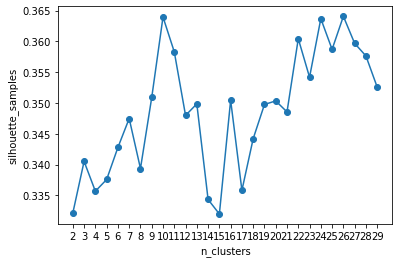

In [ ]:
# 评估指标——轮廓系数,前者为所有点的平均轮廓系数，后者返回每个点的轮廓系数
from sklearn.metrics import silhouette_score, silhouette_samples

# 根据不同的n_centers进行聚类
n_clusters = [x for x in range(2, 30)]

# 保存不同k值下的平均轮廓系数
S=[]

for i in range(len(n_clusters)):
  # 实例化k-means分类器
  clf = KMeans(n_clusters= n_clusters[i])
  y_predict = clf.fit_predict(X)
  
  # 计算平均轮廓系数
  s = silhouette_score(X, y_predict)
  # print("当k = {}\n平均轮廓系数silhouette_score= {}".format(n_clusters[i], s))
  # 利用silhouette_samples计算轮廓系数为正的点的个数
  n_s_bigger_than_zero = (silhouette_samples(X, y_predict) > 0).sum()
  # print("轮廓系数为正的点：{}/{}\n".format(n_s_bigger_than_zero, X.shape[0]))

  S.append(list([n_clusters[i],s]))

# 绘制轮廓系数与k值变化图像
S = np.array(S)
plt.plot(S[:,0],S[:,1],marker='o')
plt.xlabel('n_clusters')
plt.ylabel('silhouette_samples')
plt.xticks(S[:,0])
plt.show()

## calinski_harabasz_score评估系数
CH指标通过计算类中各点与类中心的距离平方和来度量类内的紧密度，通过计算各类中心点与数据集中心点距离平方和来度量数据集的分离度，CH指标由分离度与紧密度的比值得到。从而，CH越大代表着类自身越紧密，类与类之间越分散，即更优的聚类结果。

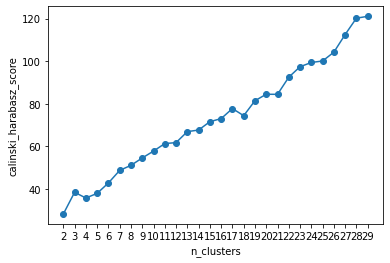

In [ ]:
# 评估指标——calinski_harabasz_score
from sklearn.metrics import calinski_harabasz_score

# 根据不同的n_centers进行聚类
n_clusters = [x for x in range(2, 30)]

# 保存不同k值下的calinski_harabasz_score
S=[]

for i in range(len(n_clusters)):
  # 实例化k-means分类器
  clf = KMeans(n_clusters= n_clusters[i])
  y_predict = clf.fit_predict(X)
  
  # 计算平均轮廓系数
  s = calinski_harabasz_score(X, y_predict)
  #print("当k = {}\ncalinski_harabasz_score= {}".format(n_clusters[i], s))

  S.append(list([n_clusters[i],s]))

# 绘制calinski_harabasz_score与k值变化图像
S = np.array(S)
plt.plot(S[:,0],S[:,1],marker='o')
plt.xlabel('n_clusters')
plt.ylabel('calinski_harabasz_score')
plt.xticks(S[:,0])
plt.show()